# 00 - DATA EXPLORATION

## EXPLORATORY ANALYSIS OF THE SOLUTIONS GENERATED BY CLAUDIA' SIMULATOR

The data collected is the solution to an instance of the Dial-a-Ride Problem with the extra constraints of using electric autonomous vehicles. 

In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt

from data_read import parse_solution, generate_solution_tables

In [2]:
rootdir = '/'.join(os.getcwd().split('/')[:-1]) #eliminate folder Python from the path

In [3]:
data_path = rootdir + "/Project_EADARP/Dynamic_eADARP/logs/solutions/"

In [4]:
try: 
    print("Reading solution tables")
    df_time = pd.read_pickle('./tables/time_sol_{}.pkl'.format(1))
    df_events = pd.read_pickle('./tables/events_sol_{}.pkl'.format(1))
    df_rides = pd.read_pickle('./tables/rides_sol_{}.pkl'.format(1))
    df_vehicles = pd.read_pickle('./tables/vehicles_sol_{}.pkl'.format(1))

except:
    print("Generating solution tables")
    for root, dirs, files in os.walk(data_path):
        sol = 1
        for file in files:
            # parse .txt solution files 
            info, times, events, rides, vehicles = parse_solution(data_path + file)

            # save information as pkl files
            generate_solution_tables(times, events, rides, vehicles, sol)

            sol += 1
    
    print("Reading solution tables")
    df_time = pd.read_pickle('./tables/time_sol_{}.pkl'.format(1))
    df_events = pd.read_pickle('./tables/events_sol_{}.pkl'.format(1))
    df_rides = pd.read_pickle('./tables/rides_sol_{}.pkl'.format(1))
    df_vehicles = pd.read_pickle('./tables/vehicles_sol_{}.pkl'.format(1))

Reading solution tables
Generating solution tables
Reading solution tables


From this we obtain 4 different tables: 
- time: contains time when the demand of each client was created
- events: each entry of the table contains information regarding the event, the location and the vehicle it concerned.
The events are encoded by an ID with the following meaning: 
    * 1: Demand generation
    * 2: Vehicle Departure
    * 3: Pickup
    * 4: Dropoff
    * 5: Vehicle Arrival
    * 6: Recharging 

- rides: for each customer, describes pickup and dropoff time as well as the vehicle which carried out the task

- vehicles: for each vehicle describes the actions performed along the throughout the whole simulation

### DATA EXPLORATION - GRAPH AND LOCATION

In [5]:
nodes_path = rootdir + "/Project_EADARP/Matlab_Uber_instances/"

In [6]:
df_nodes = pd.read_csv(nodes_path + 'nodes_location.csv')
df_edges = pd.read_csv(nodes_path + 'edges_location.csv')

In [7]:
df_edges.head(5)

,Start_node_ID,End_node_ID,Start_Lat,Start_Lon,End_Lat,End_Lon
0,1,2,37.772949,-122.422210,37.773070,-122.422046
1,2,255,37.773070,-122.422046,37.773022,-122.421949
2,3,255,37.774035,-122.420740,37.773022,-122.421949
3,4,2,37.773170,-122.422224,37.773070,-122.422046
4,2,7,37.773070,-122.422046,37.773742,-122.421187


In [8]:
print("Number of nodes: ", len(df_nodes.index))
print("Number of edges: ", len(df_edges.index))

Number of nodes:  257
Number of edges:  379


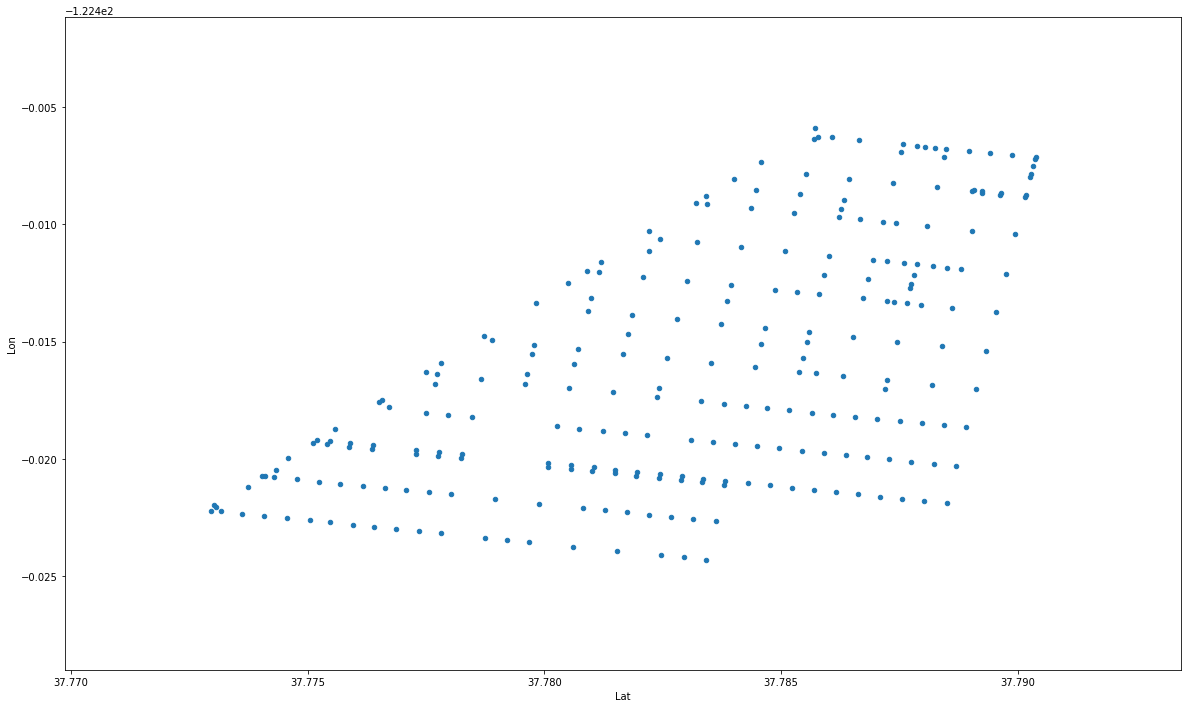

In [9]:
fig, ax = plt.subplots(figsize=(20,12))
df_nodes.plot(kind='scatter', x='Lat', y='Lon', ax=ax)
plt.show()

The data corresponds to the city of San Francisco. The nodes are identified by its longitud and latitude. The edges are identified by start and end node. 

In [10]:
min_lat, max_lat = min(df_nodes.Lat), max(df_nodes.Lat)
min_long, max_long = min(df_nodes.Lon), max(df_nodes.Lon)

width = max_lat - min_lat
height = max_long - min_long
print('LATITUDE min: {:.3f} max: {:.3f}, width: {:.3f}'.format(min_lat, max_lat, width))
print('LONGITUDE min: {:.3f} max: {:.3f}, height: {:.3f}'.format(min_long, max_long, height))

LATITUDE min: 37.773 max: 37.790, width: 0.017
LONGITUDE min: -122.424 max: -122.406, height: 0.018


### DATA EXPLORATION - DEMAND

In [11]:
# customer demand arrival
df_time['time'] = df_time['time'].apply(lambda x: float(x))
df_time['customer'] = df_time['customer'].apply(lambda x: int(x))
print('Number of demands: ', len(df_time.index))
print('Time length: ', df_time.iloc[-1, 0])
print('Time resolution', min(abs(df_time.iloc[1:len(df_time.index),0] - df_time.iloc[0:-1,0])))
df_time.head()

Number of demands:  100
Time length:  42.85
Time resolution nan


,time,customer
1,0.00,1
2,0.03,2
3,0.17,3
4,1.60,4
5,2.10,5


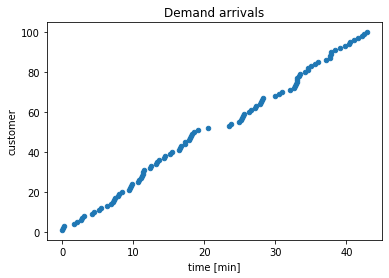

In [12]:
df_time.plot(kind='scatter', x='time', y='customer')
plt.title('Demand arrivals')
plt.xlabel('time [min]')
plt.show()

The plot shows the arrival of demands along time for 100 customers. 


In [13]:
df_rides.head()
df_rides['cust_id'] = df_rides['cust_id'].apply(lambda x: int(x))
df_demand = pd.merge(df_time, df_rides, left_on='customer', right_on='cust_id')
df_demand.drop(columns=['cust_id'], inplace=True)
df_demand['max_time'] = df_demand.dropoff_t + df_demand.excess_t
df_demand['ride_time'] = df_demand.dropoff_t - df_demand.pickup_t
df_demand.head()

,time,customer,vehicle_id,pickup_t,dropoff_t,excess_t,max_time,ride_time
0,0.00,1,1,8.605,20.046,11.441,31.487,11.441
1,0.03,2,2,7.793,10.821,3.028,13.849,3.028
2,0.17,3,1,5.545,35.049,29.504,64.553,29.504
3,1.60,4,1,9.190,28.208,19.018,47.226,19.018
4,2.10,5,1,13.770,33.729,19.959,53.688,19.959


In [14]:
df_demand.iloc[0:10]

,time,customer,vehicle_id,pickup_t,dropoff_t,excess_t,max_time,ride_time
0,0.00,1,1,8.605,20.046,11.441,31.487,11.441
1,0.03,2,2,7.793,10.821,3.028,13.849,3.028
2,0.17,3,1,5.545,35.049,29.504,64.553,29.504
3,1.60,4,1,9.190,28.208,19.018,47.226,19.018
4,2.10,5,1,13.770,33.729,19.959,53.688,19.959
5,2.57,6,3,12.571,15.667,3.096,18.763,3.096
6,2.80,7,0,0.000,0.000,0.000,0.000,0.000
7,2.98,8,0,0.000,0.000,0.000,0.000,0.000
8,4.12,9,4,15.287,43.616,28.329,71.945,28.329
9,4.52,10,4,18.029,18.968,0.939,19.907,0.939


The plot shows the demand generation, pickup and dropoff time as well as the maximum allowed time. 
The solution allows refusing customers but no dropoffs after the maximum time allowed

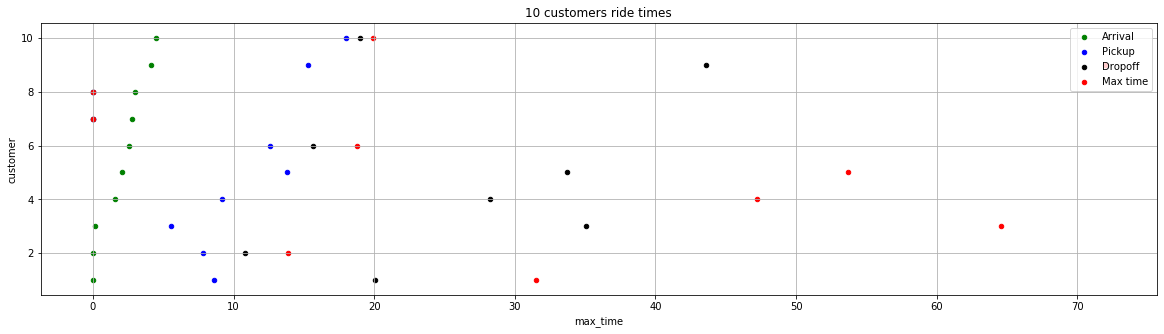

In [15]:
fig, ax = plt.subplots(figsize=(20,5))
df_demand.iloc[0:10].plot(kind='scatter', x='time', y='customer', ax=ax, c='green')
df_demand.iloc[0:10].plot(kind='scatter', x='pickup_t', y='customer', ax=ax, c='blue')
df_demand.iloc[0:10].plot(kind='scatter', x='dropoff_t', y='customer', ax=ax, c='black')
df_demand.iloc[0:10].plot(kind='scatter', x='max_time', y='customer', ax=ax, c='red')
plt.legend(['Arrival', 'Pickup', 'Dropoff', 'Max time'], loc=1)
plt.grid()
plt.title('10 customers ride times')
plt.show()

In [16]:
print('Number of refused customers: ', len(df_demand[df_demand.ride_time == 0].index))

Number of refused customers:  8


### DATA EXPLORATION - VEHICLES 

The simulation has 30 vehicles which take care of the 100 customers

In [17]:
df_vehicles.node = df_vehicles.node.apply(lambda x: int(x))
df_vehicles.wait = df_vehicles.wait.apply(lambda x: float(x))
df_vehicles['service start']  = df_vehicles['service start'].apply(lambda x: float(x))
df_vehicles['service end'] = df_vehicles['service end'].apply(lambda x: float(x))
df_vehicles.arr = df_vehicles.arr.apply(lambda x: float(x))
df_vehicles.dep = df_vehicles.dep.apply(lambda x: float(x))
df_vehicles['service t'] = df_vehicles['service t'].apply(lambda x: float(x))


df_vehicles.head()

,vehicle_number,node,wait,service start,service end,arr,dep,service t,load,battery,charging,abottom,btop
0,1,257,0.0,208.000,208.000,0.000,208.00,0.0,0,14.661130000000002,0.0,73.889,0.0
1,1,201,0.0,0.000,0.000,0.000,208.00,0.0,0,14.85,0.0,0.0,204.578
2,1,273,0.0,0.155,0.310,0.155,208.00,0.0,0,14.85,0.155,0.0,6.895
3,1,273,0.0,0.310,0.310,0.155,208.00,0.0,0,14.858525,0.0,0.0,6.895
4,1,3,0.0,5.045,5.545,0.170,15.17,0.5,1,14.5981,0.0,0.0,3.83


In [18]:
df_veh = df_vehicles[df_vehicles.vehicle_number < 15]

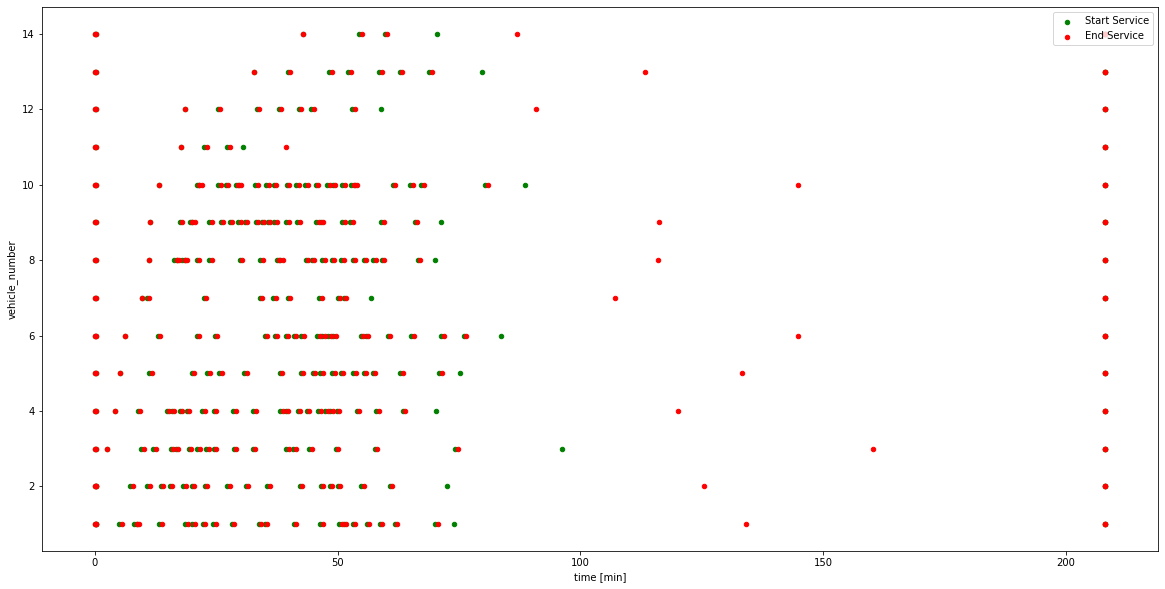

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

df_veh.plot(kind='scatter', x='service start', y='vehicle_number', c='green', ax=ax)
df_veh.plot(kind='scatter', x='service end', y='vehicle_number', c='red', ax=ax)
plt.xlabel('time [min]')
plt.legend(['Start Service', 'End Service'], loc=1)
plt.show()

### Clean up/clarify some values

- get rid of those events with inconsistent time (t=208)

In [20]:
df_events.head()

,time,vehicle_id,node,event_id,rech_time,event_description
0,0.0,1,201,2,0.0,Departure
1,0.0,2,201,2,0.0,Departure
2,0.0,3,201,2,0.0,Departure
3,0.0,4,201,2,0.0,Departure
4,0.0,5,201,2,0.0,Departure


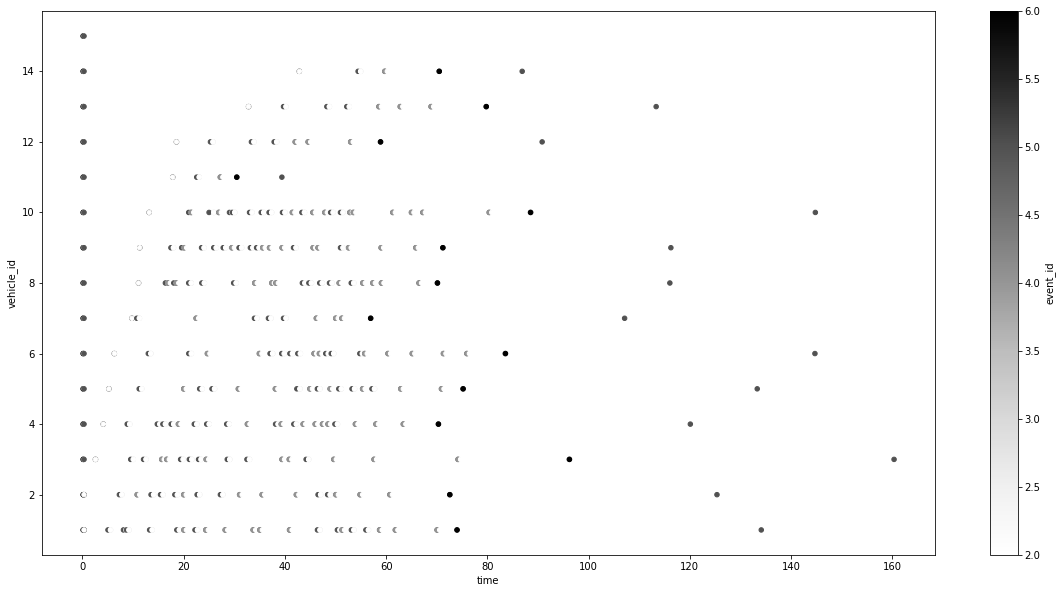

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
df_events[df_events['vehicle_id'] < 16].plot(kind='scatter', x='time', y='vehicle_id', c='event_id', ax=ax)
plt.show()

In [22]:
# we can filter out those events above 180s 
df_events.drop(df_events[df_events['time'] > 180.0].index,inplace=True)

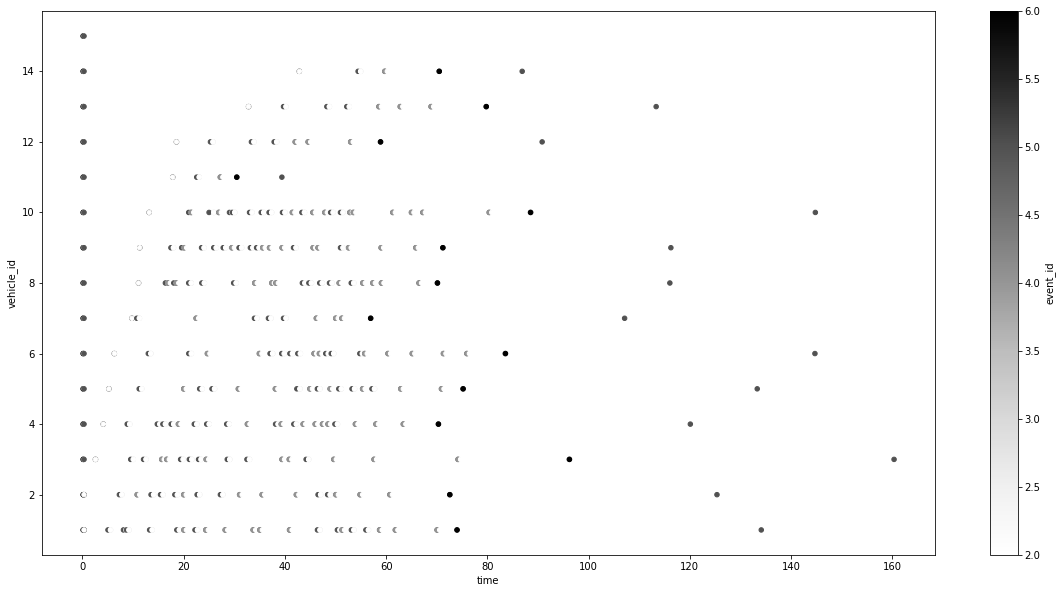

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
df_events[df_events['vehicle_id'] < 16].plot(kind='scatter', x='time', y='vehicle_id', c='event_id', ax=ax)
plt.show()

In [24]:
max_time = max(df_events.time)

print('Max time: ',max(df_events.time) ) 
print('Event: ', df_events[df_events.time == max_time].event_id)

Max time:  160.348
Event:  808    2
809    5
Name: event_id, dtype: int64


In [26]:
df_events.tail()

,time,vehicle_id,node,event_id,rech_time,event_description
805,144.715,6,299,5,0.0,Arrival
806,144.793,10,299,2,0.0,Departure
807,144.793,10,299,5,0.0,Arrival
808,160.348,3,299,2,0.0,Departure
809,160.348,3,299,5,0.0,Arrival
